In [2]:
import torch
import numpy as np
import math
import pdb
from torch.utils.data import DataLoader
import torch.nn as nn

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline
display.set_matplotlib_formats('svg')


## Generating the dataset

In [3]:
max_degree = 10
n_train, n_test = 100, 100
true_w = torch.zeros(max_degree)
true_w[:4] = torch.Tensor([5, 1.2, -3.4, 5.6])

poly_features=torch.zeros(n_train + n_test, max_degree)
features = torch.randn(n_train + n_test, 1)

for i in range(max_degree):
    poly_features[:, i] = torch.pow(features, i).squeeze()
    # rescale feature
    poly_features[:, i] /= math.gamma(i+1) # gamma(n) = (n-1)!
    
epsilon = np.random.normal(size=n_train + n_test, scale=0.1)
labels = torch.matmul(poly_features, true_w) + epsilon


In [4]:
features[5], poly_features[5,:]

(tensor([0.1321]),
 tensor([1.0000e+00, 1.3206e-01, 8.7204e-03, 3.8388e-04, 1.2674e-05, 3.3476e-07,
         7.3682e-09, 1.3901e-10, 2.2948e-12, 3.3673e-14]))

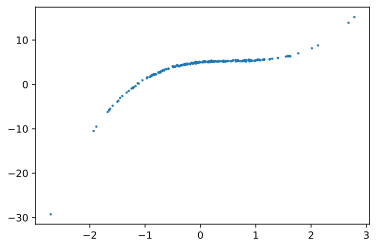

In [5]:
plt.scatter(poly_features[:,1], labels, 2)
plt.show()

In [6]:
class PolyDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        super(PolyDataset, self).__init__()
        self.features = features
        self.labels = labels
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    def __len__(self):
        return len(self.labels)

## Training and Testing the Model

In [7]:
class PolyLinearNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(PolyLinearNet, self).__init__()
        self.net = nn.Sequential(nn.Linear(in_channel, out_channel))
#         print(self.net)
#         self.initialization()
        
    def forward(self, data):
#         pdb.set_trace()
        return self.net(data)
    
    def initialization(self):
        self.net[0].weight.data = torch.Tensor(np.random.normal(size=(12, 10),scale=0.01,loc=0))
#         self.net[0].bias.data = torch.zeros(1)


In [28]:
def evaluate_loss(net, loader, loss_func):
    val_loss = []
    for idx, data in enumerate(loader):
        features, labels = data
        output = net(features)
#         pdb.set_trace()
        loss = loss_func(output.squeeze(), labels)
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [71]:
def train(epochs, lr, train_feature, train_label, test_feature, test_label, in_channel):
    batch_size = 16
#     pdb.set_trace()
    trainset = PolyDataset(train_feature, train_label)
    testset = PolyDataset(test_feature, test_label)
    train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)
    
    net = PolyLinearNet(in_channel, 1)
    loss_func = nn.MSELoss(reduction='mean')
    optim = torch.optim.SGD(net.parameters(), lr = lr)
    
    
    train_loss, test_loss = [], []
    for epo in range(epochs):
        epo_loss = []
        for idx, data in enumerate(train_loader):
            feature, label = data
#             pdb.set_trace()
            output = net(feature)
#             print(output.shape)
            optim.zero_grad()
            iter_loss = loss_func(output.squeeze(), label.float())
            iter_loss.backward()
            optim.step()

            epo_loss.append(iter_loss.item())
            
        train_loss.append(np.mean(epo_loss))
        test_loss.append(evaluate_loss(net, test_loader, loss_func))
        
        if (epo+1) % 50 == 0:
            print(f'epoch {epo} train loss: {train_loss[epo]}, test loss: {test_loss[epo]}')

    return train_loss, test_loss, net

In [75]:
train_loss, test_loss, net = train(10, 0.1, poly_features[:100, :], labels[:100], poly_features[100:, :], labels[100:], max_degree)

epoch 0 train loss: 38.84729194641113, test loss: 24.804024192479353
epoch 1 train loss: 15.81518200465611, test loss: 28.60864742409522
epoch 2 train loss: 10.11358574458531, test loss: 22.956423062808376
epoch 3 train loss: 8.095799037388392, test loss: 23.088689832493202
epoch 4 train loss: 7.148649488176618, test loss: 23.876036072983684
epoch 5 train loss: 6.10661118371146, test loss: 24.042515719385573
epoch 6 train loss: 6.921344995498657, test loss: 24.838442020914226
epoch 7 train loss: 5.0714026519230435, test loss: 29.374915054699848
epoch 8 train loss: 4.806645955358233, test loss: 28.029709124975938
epoch 9 train loss: 4.231952003070286, test loss: 26.777473955898934


## Visualization

In [10]:
def visual(train_loss, test_loss):
    plt.plot(list(range(len(train_loss))), train_loss, label='train_loss')
    plt.plot(list(range(len(test_loss))), test_loss, label='test_loss')
    
    plt.legend()
    plt.show()

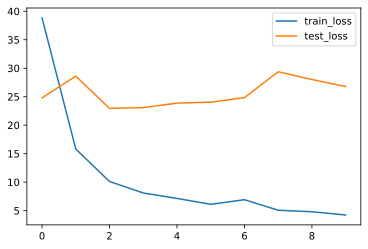

In [77]:
visual(train_loss, test_loss)

In [11]:
def plot_line(x, net):
    y = net(x)
    plt.plot(x[:,1], y.detach().numpy())
    plt.scatter(poly_features[:,1], labels, 2)
    plt.show()

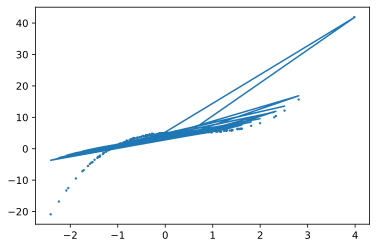

In [85]:
plot_line(poly_features, net)
# overfitting

## Third-order Polynomial Function Fitting

In [72]:
train_loss, test_loss, net = train(400, 0.01, poly_features[:100, :4], labels[:100], poly_features[100:, :4], labels[100:], 4)

epoch 49 train loss: 0.5571281356470925, test loss: 0.3459638818600994
epoch 99 train loss: 0.23643862189991133, test loss: 0.1052174960669474
epoch 149 train loss: 0.037741869421941895, test loss: 0.03099162957360376
epoch 199 train loss: 0.015390716759221894, test loss: 0.012994214051123793
epoch 249 train loss: 0.012378899314041649, test loss: 0.009185009354048876
epoch 299 train loss: 0.008841579580413443, test loss: 0.008418856390756456
epoch 349 train loss: 0.008041633093463523, test loss: 0.00927345321393884
epoch 399 train loss: 0.008412071038037539, test loss: 0.008925526316391636


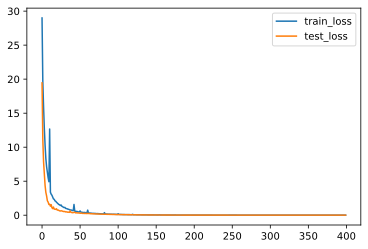

In [68]:
visual(train_loss, test_loss)

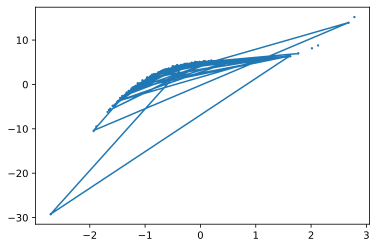

In [69]:
plot_line(poly_features[:100, :4], net)

In [59]:
print(net.net[0].weight)

Parameter containing:
tensor([[ 2.3924,  1.7101, -3.3666,  4.6019]], requires_grad=True)


## Linear Func fitting(Underfitting)

In [73]:
train_loss, test_loss, net = train(400, 0.01, poly_features[:100, :2], labels[:100], poly_features[100:, :2], labels[100:], 2)

epoch 49 train loss: 7.820588520595005, test loss: 3.372352280178063
epoch 99 train loss: 7.7646302836281915, test loss: 3.3968285009596073
epoch 149 train loss: 7.83660762650626, test loss: 3.2119548797020525
epoch 199 train loss: 7.842018944876535, test loss: 3.5098408936634633
epoch 249 train loss: 7.674488527434213, test loss: 3.5532243442199554
epoch 299 train loss: 7.947929007666452, test loss: 3.7272277324224334
epoch 349 train loss: 7.594562820025852, test loss: 3.3475564208434574
epoch 399 train loss: 7.656744718551636, test loss: 3.4730156911033623


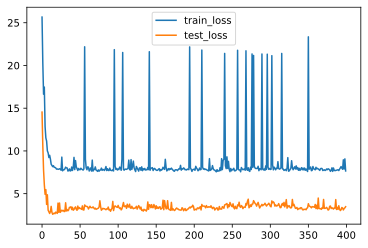

In [74]:
visual(train_loss, test_loss)

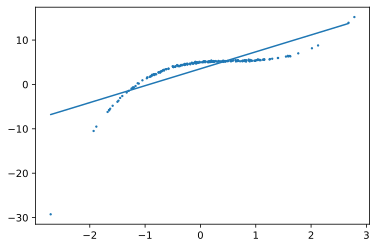

In [75]:
plot_line(poly_features[:100, :2], net)